Team Members:

* Deepan Chakravarthi Padmanabhan
* Jaswanth Bandlamudi
* Muhammad Umer Ahmed Khan

## Data:

1. Files used for compiling the positive samples (living skin): 'Archiv/Referenz-Haut_6-Klassen.csv' and 'Archiv2016/2016skin.csv'.
2. Files used for compiling the negative samples (non-living skin): 'Archiv2016/2016material.csv', 'Archiv2016/2016material-fake.csv', 'Archiv/Fleisch.csv', 'Archiv/Stoff.csv', 'Archiv/Holz.csv', and 'Archiv/Leder.csv'.

## Process flow:

$$\text{Data: Raw data provided in Archiv and Archiv 2016} \\ \downarrow  \\ \text{Data cleaning: Features with Nan values are removed in each file}  \\ \downarrow\\   \text{Visualization: Plot spectral data of each material provided} \\ \downarrow \\ \text{Combined files using same features alone. Subsampled archiv 2016 and dropped 400-660 from archiv} \\ \downarrow \\\text{Feature extraction: PCA- Extracted 5 features and normalized} \\ \downarrow \\ \text{Compiled positive and negative samples with labels} \\ \downarrow \\ \text{Shuffled data} \\ \downarrow \\ \text{Split train-test data (66.66%-33.33%)}\\ \downarrow \\ \text{Classification (Training): } \textbf{SVM-Linear Kernel, SVM-RBF Kernel, Multi-Layer Perceptron, Random Forest}\\ \downarrow \\ \text{Classifier testing and validation} \\ \downarrow\\ \text{Visualize classification metrics for comparison: }\textbf{Accuracy, Precision, Recall, Model memory size, Training time}$$ 

##### Reported cross-validation- mean roc_auc score for each classifier.  #####

## Results and discussion:

##### Provided at the end of the notebook #####

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import decomposition, model_selection
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE


import warnings
warnings.filterwarnings('ignore')

import time
import sys,os

import seaborn as sns

import keras
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.patches as patches

from memory_profiler import profile
%load_ext memory_profiler

# Memeory profiler


Using TensorFlow backend.


In [2]:
def read_csv_file(filename, decimal_=','):
    data = pd.read_csv(filename, decimal = decimal_, delimiter = ';', low_memory=False, encoding='utf8')
    return data

In [3]:
# Reading all data files

data_material = read_csv_file('Archiv2016/2016material.csv', decimal_='.')
data_fake_material = read_csv_file('Archiv2016/2016material-fake.csv', decimal_='.')
data_skin = read_csv_file('Archiv2016/2016skin.csv', decimal_='.')
data_reference = read_csv_file('Archiv2016/Referenz-Haut_6-Klassen.csv', decimal_=',')

data_flesh = read_csv_file('Archiv/Fleisch.csv', decimal_=',')
data_stoff = read_csv_file('Archiv/Stoff.csv', decimal_=',')
data_holz = read_csv_file('Archiv/Holz.csv', decimal_=',')
data_leder = read_csv_file('Archiv/Leder.csv', decimal_=',')
data_2reference = read_csv_file('Archiv/Referenz-Haut_6-Klassen.csv', decimal_=',')


In [4]:
# Neglecting features (wavelength) with Nan values

data_material = data_material.dropna()
data_fake_material = data_fake_material.dropna()
data_skin = data_skin.dropna()
data_reference = data_reference.dropna()
data_flesh = data_flesh.dropna()
data_stoff = data_stoff.dropna()
data_holz = data_holz.dropna()
data_leder = data_leder.dropna()
data_2reference = data_2reference.dropna()


In [5]:
# Plotting spectra
def plot_spectra(data, title):  
    x = list(data.iloc[:,0])
    columns = data.columns
    plt.figure(figsize=(12,8))
    for i in columns[1:]:
        plt.plot(x,data[i])
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title(title)
    plt.show()

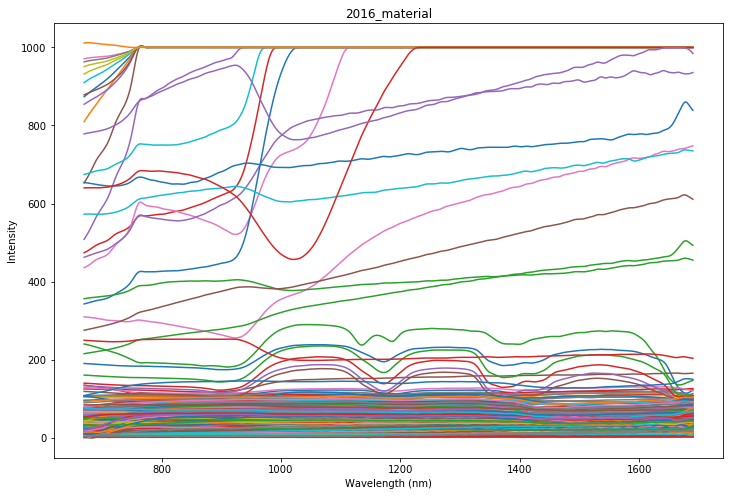

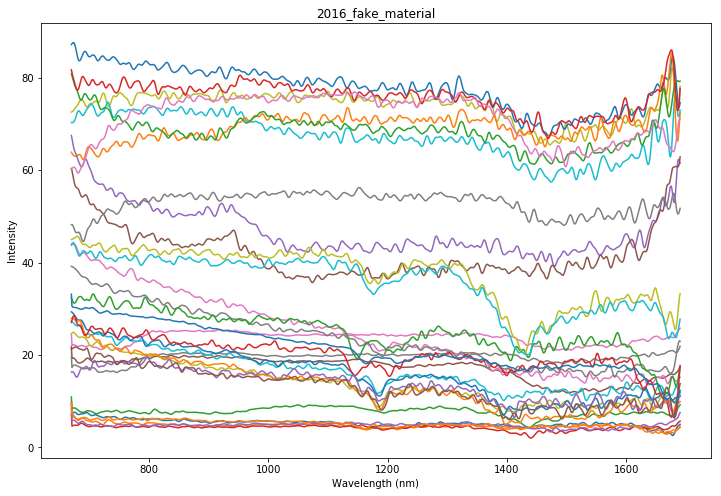

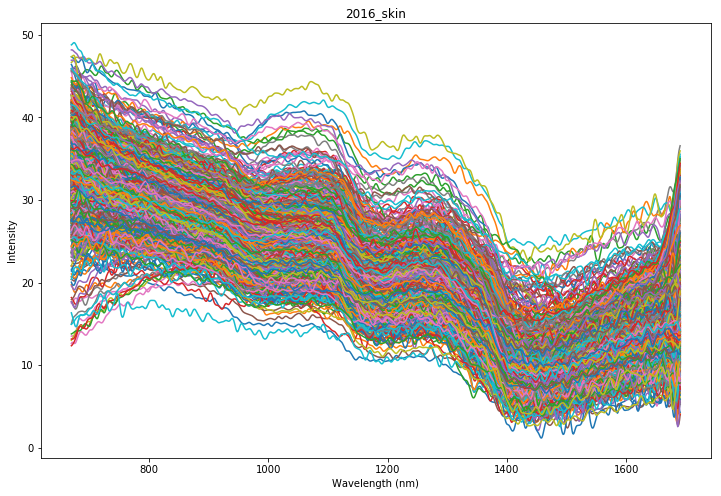

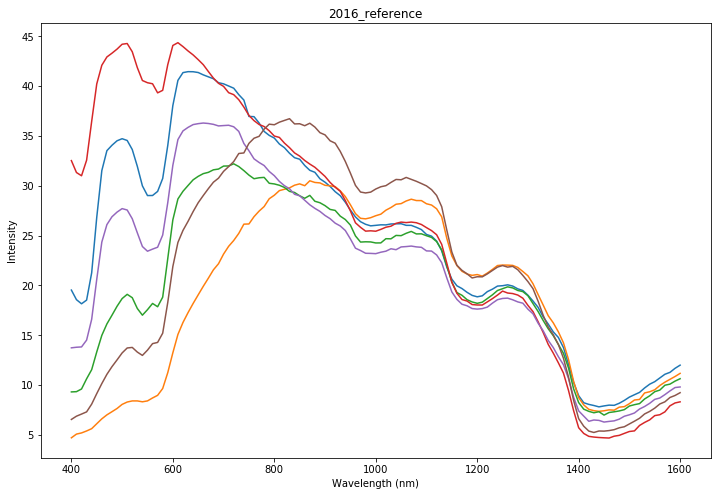

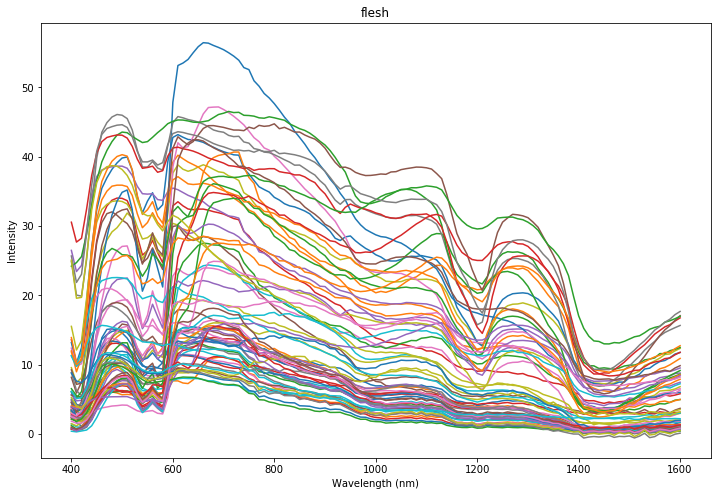

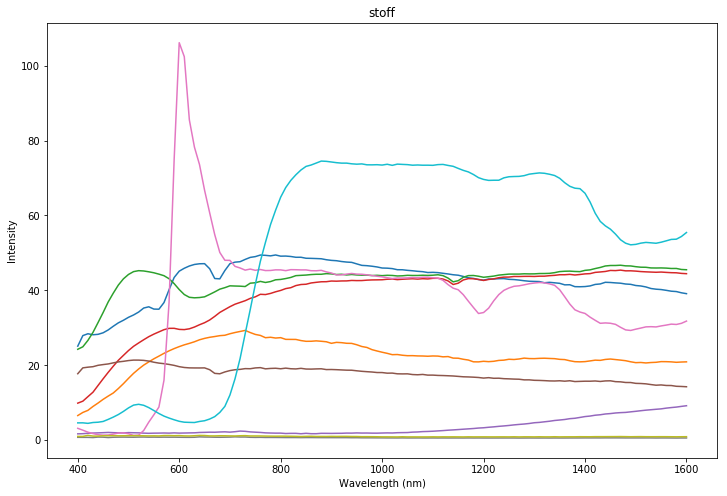

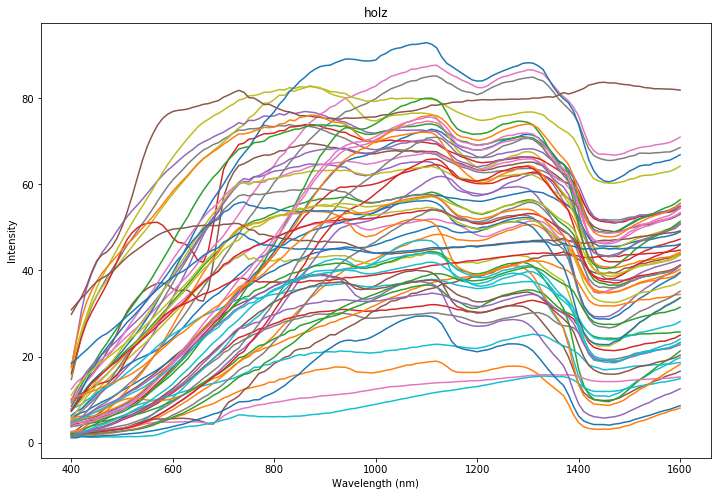

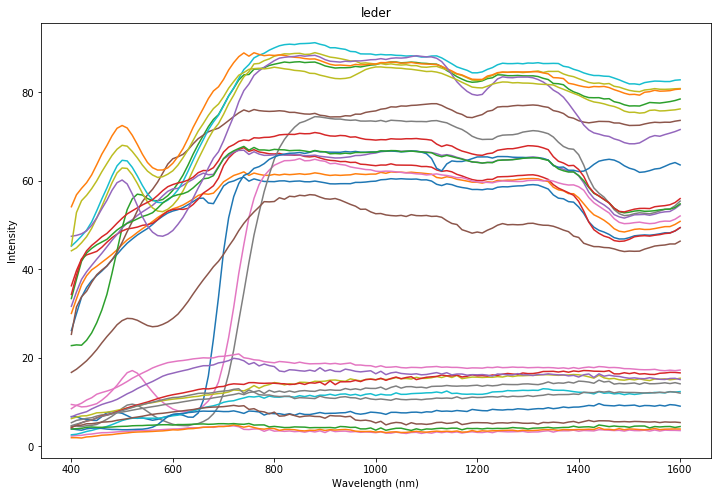

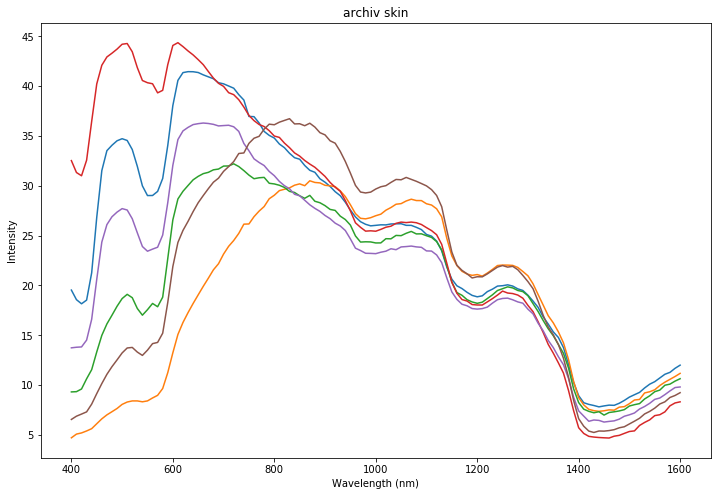

In [6]:
plot_spectra(data_material,'2016_material')
plot_spectra(data_fake_material,'2016_fake_material')
plot_spectra(data_skin,'2016_skin')
plot_spectra(data_reference,'2016_reference')

plot_spectra(data_flesh,'flesh')
plot_spectra(data_stoff,'stoff')
plot_spectra(data_holz,'holz')
plot_spectra(data_leder,'leder')
plot_spectra(data_2reference, 'archiv skin')

Notes:

1. Referenz-Haut_6-Klassen.csv in archiv and archiv 2016 are the same.

2. As seen above from the graphs all the materials are tested in various wavelengths making the number of features (along the x axis) unequal. In order to take a common feature representation numerous methods like imputation, feature split, dimensionality reduction can be applied as per [1].

In [7]:
def find_csv(folder_name):
    file_list= []
    for root, dirs, files in os.walk(folder_name):
        for file in files:
            if file.endswith(".csv"):
                 file_list.append(os.path.join(root, file))
    return file_list 

def normalize_data(df):
    scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
    x_scale = scaler.fit_transform(df.iloc[:,1:]) # do not scale nm scale
    df_scalled = pd.DataFrame(x_scale)
    df_scalled.insert(0, 'nm', df['nm'])
    return df_scalled

def add_lables(df, filename):
    if(("skin" in filename.lower()) or ("haut" in filename.lower())):
        df['label']=[1]*df.shape[0]
    else:
        df['label']=[0]*df.shape[0]
    return df

def merge_data(folder):
    df_merged = pd.DataFrame()
    files = find_csv(folder)
    for i,file in enumerate(files):
        if("2016" in folder):
            if("Referenz-Haut_6-Klassen.csv" in file):
                continue
        df = read_csv_file(file)
        df = normalize_data(df)
        df = add_lables(df.transpose(), file)
        df_merged = df_merged.append(df.iloc[1:,:])
        df_merged = df_merged.fillna(0.0)
    return df_merged

dummy = read_csv_file("Archiv/Referenz-Haut_6-Klassen.csv").T
archiv_columns = list(dummy.iloc[0,:])
archiv_columns.append("label")

data_archive = merge_data("Archiv/")
data_archive.columns = archiv_columns

dummy = read_csv_file("Archiv2016/2016material-fake.csv").T
archiv2016_columns = list(dummy.iloc[0,:])
archiv2016_columns.append("label")

data_archive2016 = merge_data("Archiv2016/")
data_archive2016.columns = archiv2016_columns

#Subsample the archiv 2016 folder
subsampled_archiv2016 = data_archive2016[archiv_columns[27:]]
subsample_archiv_colums= list(subsampled_archiv2016.columns.values)

#Drop data from 400 to 660 nm from archiv data
subsampled_archiv = data_archive[subsample_archiv_colums]

#Combine both data
final_data = pd.concat([subsampled_archiv, subsampled_archiv2016])

print("Observations in the combined data: {}".format(final_data.shape[0]))
print("Total features in the combined data : {}".format(final_data.shape[1]))
print("\nTotal living skin : {}".format(len(np.where(final_data["label"]==1)[0])))
print("Total dead skin : {}".format(len(np.where(final_data["label"]==0)[0])))


Observations in the combined data: 1655
Total features in the combined data : 95

Total living skin : 1117
Total dead skin : 538


In [8]:
def PCA_(X, k):
    # PCA for the data and taking k features
    pca = decomposition.PCA(n_components=k)
    pca_data  = pca.fit_transform(X)
    return pca_data
    

In [10]:
y = final_data['label']

X_5d = PCA_(final_data.iloc[:,:-1],5)
X = X_5d

X = Features and y = labels are ready for learning and developing classifier.

In [11]:
X.shape

(1655, 5)

In [13]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes= ['Non-living skin', 'Living skin'],
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, plot_file_name=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label- Actual class',
           xlabel='Predicted label- Predicted class')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.suptitle(plot_file_name,fontsize=22)
    fig.subplots_adjust(top=0.8)
    plt.show()
    return ax

## SVM

In [14]:
# Shuffling the dataset
X, y = shuffle(X, y)

# Splitting train-test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

In [15]:
# SVM Linear
svm_linear = svm.SVC(C=10, kernel='linear', gamma='auto')
start = time.time()
%memit svm_linear.fit(X_train,y_train)
end = time.time()
svm_linear_time = end - start
print("Training time taken for SVM-Linear kernel (in seconds): ",end - start)

peak memory: 491.85 MiB, increment: 1.64 MiB
Training time taken for SVM-Linear kernel (in seconds):  0.32253050804138184


In [16]:
def svm_linear_fun(X_train,y_train):
    svm_linear = svm.SVC(C=10, kernel='linear', gamma='auto')
    start = time.time()
    svm_linear.fit(X_train,y_train)
    end = time.time()
    svm_linear_time = end - start
    print("Training time taken for SVM-Linear kernel (in seconds): ",end - start)
    
%memit svm_linear_fun(X_train,y_train)

Training time taken for SVM-Linear kernel (in seconds):  0.04933452606201172
Training time taken for SVM-Linear kernel (in seconds):  0.02460455894470215
peak memory: 491.88 MiB, increment: 0.01 MiB


peak memory: 491.89 MiB, increment: 0.00 MiB
=== Confusion Matrix SVM-Linear Kernel Classifier===
[[147  20]
 [ 11 369]]


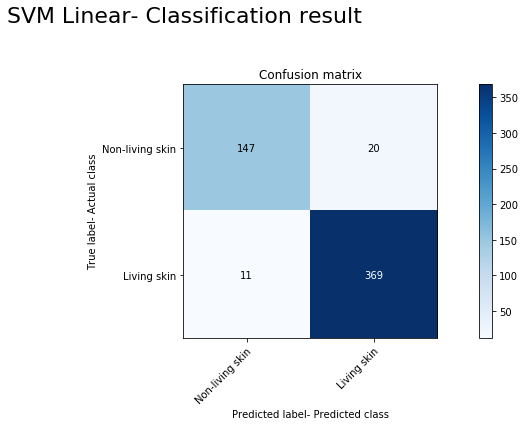



=== Classification Report SVM-Linear Kernel Classifier===
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       167
           1       0.95      0.97      0.96       380

   micro avg       0.94      0.94      0.94       547
   macro avg       0.94      0.93      0.93       547
weighted avg       0.94      0.94      0.94       547



=== Accuracy SVM-Linear Kernel Classifier===
0.943327239488117


=== Precision SVM-Linear Kernel Classifier===
0.9485861182519281


=== Recall SVM-Linear Kernel Classifier===
0.9710526315789474




In [17]:
# prediction
%memit svm_predict = svm_linear.predict(X_test)

print("=== Confusion Matrix SVM-Linear Kernel Classifier===")
print(confusion_matrix(y_test, svm_predict))
class_names = ['Non-living skin', 'Living skin']

plot_confusion_matrix(y_test,svm_predict, classes=class_names,
                      title='Confusion matrix', plot_file_name='SVM Linear- Classification result')
print('\n')

print("=== Classification Report SVM-Linear Kernel Classifier===")
print(classification_report(y_test, svm_predict))
print('\n')

print("=== Accuracy SVM-Linear Kernel Classifier===")
svm_linear_accuracy = accuracy_score(y_test, svm_predict)
print(svm_linear_accuracy)
print('\n')

print("=== Precision SVM-Linear Kernel Classifier===")
svm_linear_precision = precision_score(y_test, svm_predict)
print(svm_linear_precision)
print('\n')


print("=== Recall SVM-Linear Kernel Classifier===")
svm_linear_recall = recall_score(y_test, svm_predict)
print(svm_linear_recall)
print('\n')

In [18]:
svm_linear_cv = svm.SVC(C=10, kernel='linear', gamma='auto')
start = time.time()
svm_linear_cv_score = cross_val_score(svm_linear_cv, X, y, cv=5, scoring='roc_auc')
end = time.time()
print("=== All AUC Scores SVM-Linear Classifier===")

print(svm_linear_cv_score)
print('\n')

print("=== Mean AUC Score SVM-Linear Kernel Classifier: ===")
print(svm_linear_cv_score.mean())
print('\n')

print("Time taken for cross validation SVM-Linear kernel (in seconds): ",end - start,"seconds")

=== All AUC Scores SVM-Linear Classifier===
[0.98048942 0.96230159 0.98227039 0.97389045 0.95117556]


=== Mean AUC Score SVM-Linear Kernel Classifier: ===
0.9700254799124293


Time taken for cross validation SVM-Linear kernel (in seconds):  0.1603686809539795 seconds


In [19]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    print("CV score, test_scores", test_scores_mean)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CV score, test_scores [0.93504532 0.93981873 0.94006042 0.94072508 0.94048338]


<Figure size 1152x360 with 0 Axes>

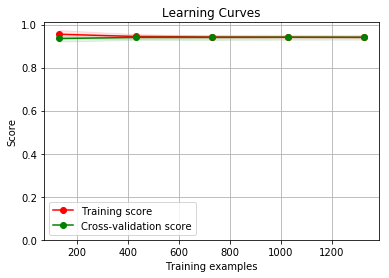

In [20]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
f = plt.figure(figsize=(16,5))
plt.subplots_adjust(left=None,bottom=0.1,top=0.9,wspace=0.2,hspace=0.5)

estimator = svm_linear
title = r"Learning Curves"
plot_learning_curve(estimator, title, X, y, ylim=(0, 1.01), cv=cv, n_jobs=4)

fig1 = plt.gcf()
plt.draw()

## Radial Basis Function Kernel SVM

In [21]:
X, y = shuffle(X, y)

# Splitting train-test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

In [22]:
svm_rbf = svm.SVC(C=1, kernel='rbf', gamma=10)
start = time.time()
%memit svm_rbf.fit(X_train,y_train)
end = time.time()
svm_rbf_time = end - start
print("Training time taken for SVM-RBF Kernel (in seconds): ",svm_rbf_time)

peak memory: 492.70 MiB, increment: -0.00 MiB
Training time taken for SVM-RBF Kernel (in seconds):  0.2982156276702881


In [23]:
def svm_rbf_fun(X_train,y_train):
    svm_linear = svm.SVC(C=10, kernel='rbf', gamma=10)
    start = time.time()
    svm_linear.fit(X_train,y_train)
    end = time.time()
    svm_linear_time = end - start
    print("Training time taken for SVM-Linear kernel (in seconds): ",end - start)
    
%memit svm_rbf_fun(X_train,y_train)

Training time taken for SVM-Linear kernel (in seconds):  0.06609654426574707
Training time taken for SVM-Linear kernel (in seconds):  0.040452003479003906
peak memory: 492.70 MiB, increment: 0.00 MiB


peak memory: 492.70 MiB, increment: 0.00 MiB
=== Confusion Matrix SVM-RBF Kernel Classifier===
[[173   4]
 [ 30 340]]


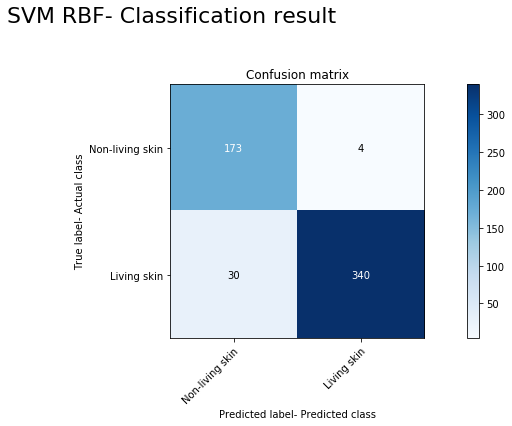



=== Classification Report SVM-RBF Kernel Classifier===
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       177
           1       0.99      0.92      0.95       370

   micro avg       0.94      0.94      0.94       547
   macro avg       0.92      0.95      0.93       547
weighted avg       0.94      0.94      0.94       547



=== Accuracy SVM-RBF Kernel Classifier===
0.9378427787934186


=== Precision SVM-RBF Kernel Classifier===
0.9883720930232558


=== Recall SVM-RBF Kernel Classifier===
0.918918918918919




In [24]:
# predictions
%memit svm_predict = svm_rbf.predict(X_test)

print("=== Confusion Matrix SVM-RBF Kernel Classifier===")
print(confusion_matrix(y_test, svm_predict))
plot_confusion_matrix(y_test,svm_predict, classes=class_names,
                      title='Confusion matrix', plot_file_name='SVM RBF- Classification result')
print('\n')

print("=== Classification Report SVM-RBF Kernel Classifier===")
print(classification_report(y_test, svm_predict))
print('\n')

print("=== Accuracy SVM-RBF Kernel Classifier===")
svm_rbf_accuracy = accuracy_score(y_test, svm_predict)
print(svm_rbf_accuracy)
print('\n')

print("=== Precision SVM-RBF Kernel Classifier===")
svm_rbf_precision = precision_score(y_test, svm_predict)
print(svm_rbf_precision)
print('\n')


print("=== Recall SVM-RBF Kernel Classifier===")
svm_rbf_recall = recall_score(y_test, svm_predict)
print(svm_rbf_recall)
print('\n')

In [25]:
svm_rbf_cv = svm.SVC(C=1, kernel='rbf', gamma=10)
svm_rbf_cv_score = cross_val_score(svm_rbf_cv, X, y, cv=5, scoring='roc_auc')

print("=== All AUC Scores SVM-RBF Kernel Classifier===")

print(svm_rbf_cv_score)
print('\n')

print("=== Mean AUC Score SVM-RBF Kernel Classifier ===")
print(svm_rbf_cv_score.mean())

=== All AUC Scores SVM-RBF Kernel Classifier===
[0.99479167 0.99024471 0.9988374  0.99673107 0.98608608]


=== Mean AUC Score SVM-RBF Kernel Classifier ===
0.9933381854818771


CV score, test_scores [0.88205438 0.93906344 0.94791541 0.95271903 0.95670695]


<Figure size 1152x360 with 0 Axes>

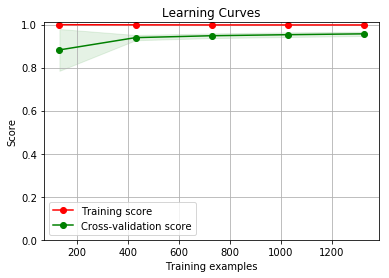

In [26]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
f = plt.figure(figsize=(16,5))
plt.subplots_adjust(left=None,bottom=0.1,top=0.9,wspace=0.2,hspace=0.5)

estimator = svm_rbf
title = r"Learning Curves"
plot_learning_curve(estimator, title, X, y, ylim=(0, 1.01), cv=cv, n_jobs=4)

fig1 = plt.gcf()
plt.draw()

## Multi Layer Perceptron

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

In [28]:
# Using sklearn

# Hyper parameter optimization - Finding best parameters using Gridsearch
parameter_space = {
    'hidden_layer_sizes': [(10,10,10), (5,10), (10,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp_sklearn = MLPClassifier(max_iter=100, random_state=1)
mlp_sklearn = model_selection.GridSearchCV(mlp_sklearn, parameter_space, n_jobs=-1, cv=3)
%memit mlp_sklearn.fit(X_train, y_train)
# Best model found by HPO
print("Best model", mlp_sklearn)
predicted = mlp_sklearn.predict(X_test)

print("=== Accuracy MLP Classifier===")
mlp_accuracy = accuracy_score(y_test, predicted)
print(mlp_accuracy)
print('\n')

print("=== Precision MLP Classifier===")
mlp_precision = precision_score(y_test, predicted)
print(mlp_precision)
print('\n')


print("=== Recall MLP Classifier===")
mlp_recall = recall_score(y_test, predicted)
print(mlp_recall)
print('\n')

peak memory: 493.36 MiB, increment: 0.27 MiB
Best model GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'solver': ['sgd', 'adam'], 'learning_rate': ['constant', 'adaptive'], 'activation': ['tanh', 'relu'], 'alpha': [0.0001, 0.05], 'hidden_layer_sizes': [(10, 10, 10), (5, 10), (10,)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
=== Accuracy MLP Classifier===
0.9652650822669104


=== Precision MLP C

Epoch 1/100
1108/1108 [==============================] - 0s 186us/step - loss: 0.2035 - accuracy: 0.9395
Epoch 2/100
1108/1108 [==============================] - 0s 93us/step - loss: 0.1249 - accuracy: 0.9603
Epoch 3/100
1108/1108 [==============================] - 0s 91us/step - loss: 0.1120 - accuracy: 0.9666
Epoch 4/100
1108/1108 [==============================] - 0s 103us/step - loss: 0.1011 - accuracy: 0.9702
Epoch 5/100
1108/1108 [==============================] - 0s 100us/step - loss: 0.0978 - accuracy: 0.9774
Epoch 6/100
1108/1108 [==============================] - 0s 95us/step - loss: 0.0874 - accuracy: 0.9756
Epoch 7/100
1108/1108 [==============================] - 0s 118us/step - loss: 0.0804 - accuracy: 0.9801
Epoch 8/100
1108/1108 [==============================] - 0s 96us/step - loss: 0.0857 - accuracy: 0.9792
Epoch 9/100
1108/1108 [==============================] - 0s 90us/step - loss: 0.0895 - accuracy: 0.9765
Epoch 10/100
1108/1108 [==============================] - 0s

1108/1108 [==============================] - 0s 86us/step - loss: 0.0423 - accuracy: 0.9928
Epoch 80/100
1108/1108 [==============================] - 0s 81us/step - loss: 0.0391 - accuracy: 0.9928
Epoch 81/100
1108/1108 [==============================] - 0s 80us/step - loss: 0.1154 - accuracy: 0.9819
Epoch 82/100
1108/1108 [==============================] - 0s 80us/step - loss: 0.0723 - accuracy: 0.9874
Epoch 83/100
1108/1108 [==============================] - 0s 80us/step - loss: 0.0529 - accuracy: 0.9865
Epoch 84/100
1108/1108 [==============================] - 0s 81us/step - loss: 0.0418 - accuracy: 0.9919
Epoch 85/100
1108/1108 [==============================] - 0s 83us/step - loss: 0.0389 - accuracy: 0.9919
Epoch 86/100
1108/1108 [==============================] - 0s 82us/step - loss: 0.0399 - accuracy: 0.9919
Epoch 87/100
1108/1108 [==============================] - 0s 103us/step - loss: 0.0401 - accuracy: 0.9928
Epoch 88/100
1108/1108 [==============================] - 0s 89us/s

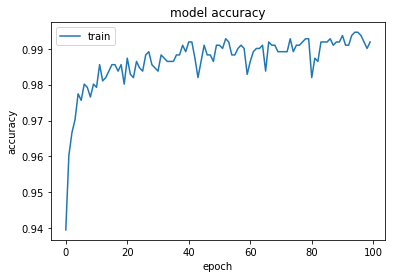

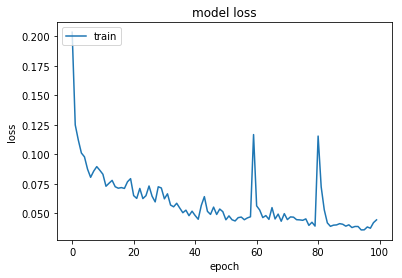

=== Confusion matrix of MLP Classifier===
=== Depiction ===
 [['TP' 'FN']
 ['FP' 'TN']]
=== Estimated values ===
 [[167  10]
 [  5 365]]


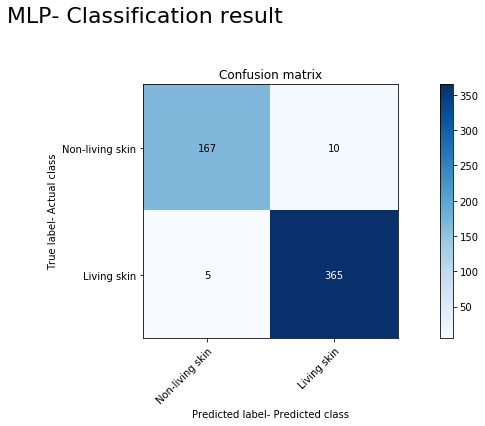

=== Precision of MLP Classifier===
 0.9733333333333334
=== Recall of MLP Classifier===
 0.9864864864864865
=== Accuracy MLP Classifier===
 0.9725776965265083
Training time taken for MLP with 3 hidden layers (in seconds):  10.474331855773926


In [29]:
# MLP with 3 hidden layers and a output layer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)
input_ = Input(shape=(X_train.shape[1],)) # input
hidden_1 = Dense(12, activation='relu')(input_) # inputs * weights 
hidden_2 = Dense(12, activation='relu')(hidden_1) # hidden * weights
hidden_3 = Dense(12, activation='relu')(hidden_2)
output_ = Dense(1, activation='sigmoid')(hidden_3)
classifier = Model(input_, output_)

# Optimizer and loss function definition
classifier.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics = ['accuracy'] )
# For weight balancing on unbalanced dataset.
weights = compute_class_weight('balanced', np.array([0,1]), y_train)

start_ = time.time()
%memit history = classifier.fit(X_train, y_train, batch_size=10, epochs=100, class_weight={0:weights[0],1:weights[1]})
stop_ = time.time()
predicted_labels = classifier.predict(X_test)
predicted_labels = np.array([i > 0.5 for i in predicted_labels])
# Map probabilities to class labels

mlp_time = stop_ - start_
predictions = predicted_labels

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

mlp_accuracy = accuracy_score(y_test, predictions)
mlp_precision = precision_score(y_test, predictions, [1,0])
mlp_recall = recall_score(y_test, predictions, [1,0])

print ("=== Confusion matrix of MLP Classifier===")
print ("=== Depiction ===\n",np.array([["TP", "FN"], ["FP", "TN"]]))
print ("=== Estimated values ===\n",confusion_matrix(y_test, predictions, [0,1]))
plot_confusion_matrix(y_test,predictions, classes=class_names,
                      title='Confusion matrix', plot_file_name='MLP- Classification result')
print ("=== Precision of MLP Classifier===\n",mlp_precision)
print ("=== Recall of MLP Classifier===\n",mlp_recall)
print("=== Accuracy MLP Classifier===\n", mlp_accuracy)
print("Training time taken for MLP with 3 hidden layers (in seconds): ",mlp_time)        

## Random forest

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

In [31]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
# random forest model creation
rfc = RandomForestClassifier()
start = time.time()
%memit rfc.fit(X_train,y_train)
end = time.time()
random_forest_time = end - start
print("Training time taken for Random Forest with 10 estimators (in seconds): ",random_forest_time)        

peak memory: 508.23 MiB, increment: 0.04 MiB
Training time taken for Random Forest with 10 estimators (in seconds):  0.3042469024658203


peak memory: 508.24 MiB, increment: 0.01 MiB
=== Confusion Matrix Random forest Classifier===
[[168   9]
 [ 11 359]]


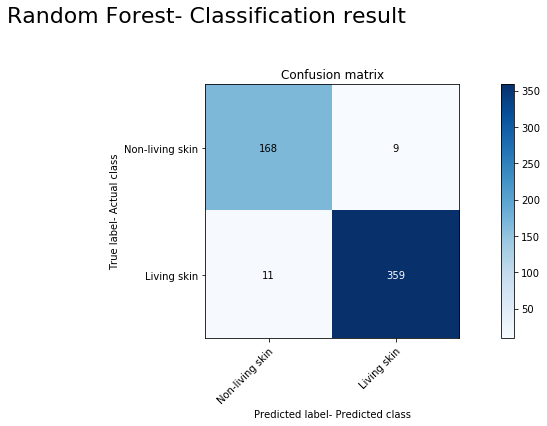



=== Classification Report Random forest Classifier===
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       177
           1       0.98      0.97      0.97       370

   micro avg       0.96      0.96      0.96       547
   macro avg       0.96      0.96      0.96       547
weighted avg       0.96      0.96      0.96       547



=== Accuracy Random forest Classifier===
0.9634369287020109


=== Precision Random forest Classifier===
0.9755434782608695


=== Recall Random forest Classifier===
0.9702702702702702




In [32]:
%memit rfc_predict = rfc.predict(X_test)

print("=== Confusion Matrix Random forest Classifier===")
print(confusion_matrix(y_test, rfc_predict))
plot_confusion_matrix(y_test,rfc_predict, classes=class_names,
                      title='Confusion matrix', plot_file_name='Random Forest- Classification result')
print('\n')

print("=== Classification Report Random forest Classifier===")
print(classification_report(y_test, rfc_predict))
print('\n')

print("=== Accuracy Random forest Classifier===")
random_forest_accuracy = accuracy_score(y_test, rfc_predict)
print(random_forest_accuracy)
print('\n')

print("=== Precision Random forest Classifier===")
random_forest_precision = precision_score(y_test, rfc_predict)
print(random_forest_precision)
print('\n')


print("=== Recall Random forest Classifier===")
random_forest_recall = recall_score(y_test, rfc_predict)
print(random_forest_recall)
print('\n')

In [33]:
rfc_cv = RandomForestClassifier()
rfc_cv_score = cross_val_score(rfc_cv, X, y, cv=5, scoring='roc_auc')

print("=== All AUC Scores Random Forest Classifier===")

print(rfc_cv_score)
print('\n')

print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest Classifier: ", rfc_cv_score.mean())

=== All AUC Scores Random Forest Classifier===
[0.98123347 0.9936756  0.9993149  0.98987888 0.98583463]


=== Mean AUC Score ===
Mean AUC Score - Random Forest Classifier:  0.9899874932202135


CV score, test_scores [0.95024169 0.96453172 0.96867069 0.97108761 0.97320242]


<Figure size 1152x360 with 0 Axes>

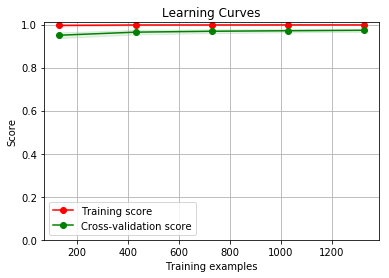

In [34]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
f = plt.figure(figsize=(16,5))
plt.subplots_adjust(left=None,bottom=0.1,top=0.9,wspace=0.2,hspace=0.5)

estimator = rfc
title = r"Learning Curves"
plot_learning_curve(estimator, title, X, y, ylim=(0, 1.01), cv=cv, n_jobs=4)

fig1 = plt.gcf()
plt.draw()

## Results:

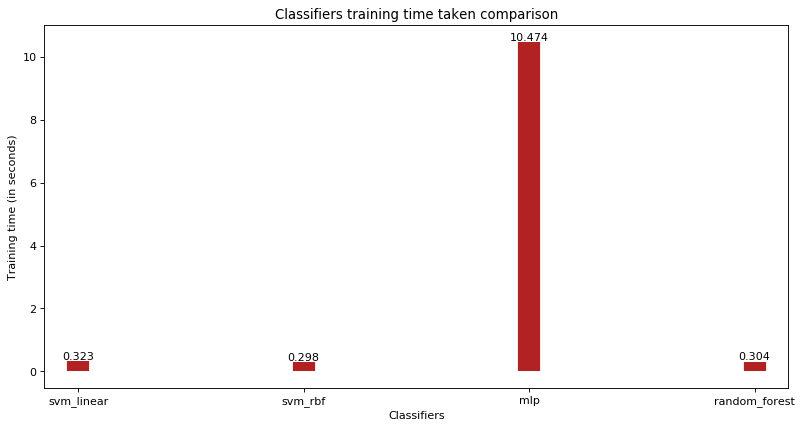

In [35]:
timer = [svm_linear_time, svm_rbf_time, mlp_time, random_forest_time]
LABELS = ['svm_linear', 'svm_rbf', 'mlp', 'random_forest']

fig, ax = plt.subplots(figsize=(12,6), facecolor='white', dpi= 80)
ax.vlines(x=LABELS, ymin=0, ymax=timer, color='firebrick', alpha=1, linewidth=20)

# Annotate Text
for i, value in enumerate(timer):
    ax.text(i, value+0.05, round(value,3), horizontalalignment='center')
plt.ylabel('Training time (in seconds)')
plt.xlabel('Classifiers')
plt.title('Classifiers training time taken comparison')
plt.show()


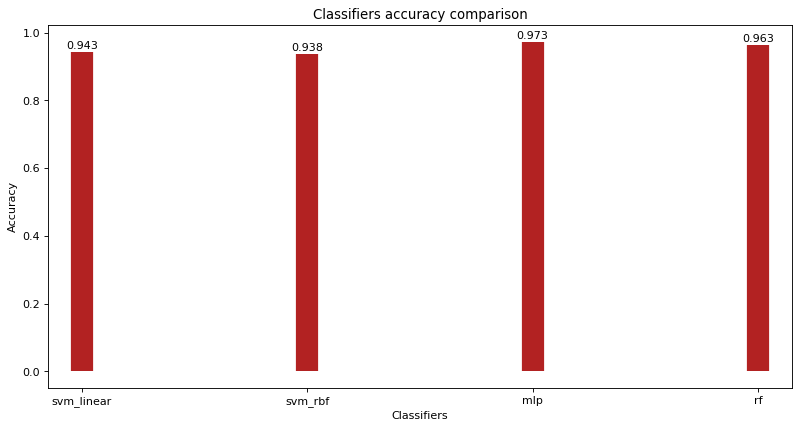

In [36]:
accuracy_ = [svm_linear_accuracy, svm_rbf_accuracy, mlp_accuracy, random_forest_accuracy]
LABELS = ['svm_linear', 'svm_rbf', 'mlp', 'rf']

fig, ax = plt.subplots(figsize=(12,6), facecolor='white', dpi= 80)
ax.vlines(x=LABELS, ymin=0, ymax=accuracy_, color='firebrick', alpha=1, linewidth=20)

# Annotate Text
for i, value in enumerate(accuracy_):
    ax.text(i, value+0.01, round(value,3), horizontalalignment='center')
plt.ylabel('Accuracy')
plt.xlabel('Classifiers')
plt.title('Classifiers accuracy comparison')
plt.show()

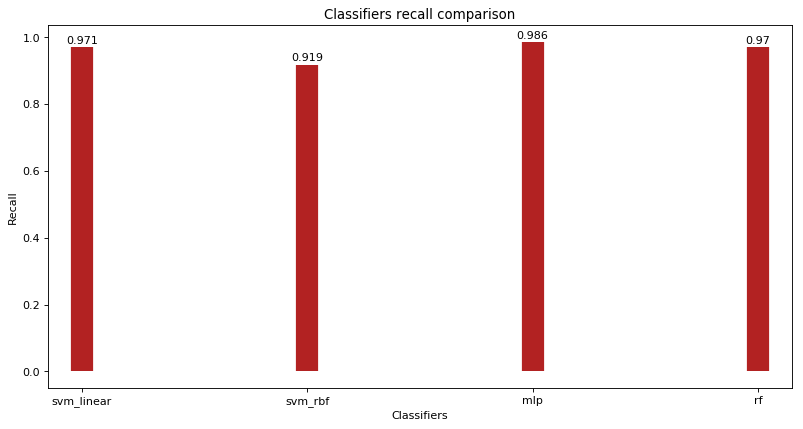

In [37]:
recall = [svm_linear_recall, svm_rbf_recall, mlp_recall, random_forest_recall]
x_range = range(len(recall))
LABELS = ['svm_linear', 'svm_rbf', 'mlp', 'rf']

fig, ax = plt.subplots(figsize=(12,6), facecolor='white', dpi= 80)
ax.vlines(x=LABELS, ymin=0, ymax=recall, color='firebrick', alpha=1, linewidth=20)

# Annotate Text
for i, value in enumerate(recall):
    ax.text(i, value+0.01, round(value,3), horizontalalignment='center')
plt.ylabel('Recall')
plt.xlabel('Classifiers')
plt.title('Classifiers recall comparison')
plt.show()

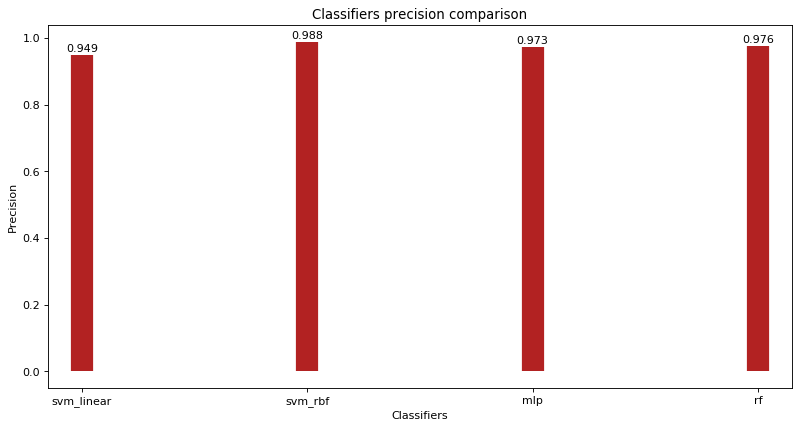

In [38]:
precision = [svm_linear_precision, svm_rbf_precision, mlp_precision, random_forest_precision]
LABELS = ['svm_linear', 'svm_rbf', 'mlp', 'rf']

fig, ax = plt.subplots(figsize=(12,6), facecolor='white', dpi= 80)
ax.vlines(x=LABELS, ymin=0, ymax=precision, color='firebrick', alpha=1, linewidth=20)

# Annotate Text
for i, value in enumerate(precision):
    ax.text(i, value+0.01, round(value,3), horizontalalignment='center')
plt.ylabel('Precision')
plt.xlabel('Classifiers')
plt.title('Classifiers precision comparison')
plt.show()

In [39]:
import os, pickle
svm_linear_filename = 'svm_model.pkl'
pickle.dump(svm_linear, open(svm_linear_filename, 'wb'))

svm_rbf_filename = 'svm_model.pkl'
pickle.dump(svm_rbf, open(svm_rbf_filename, 'wb'))

mlp_filename = 'mlp_model.pkl'
pickle.dump(classifier, open(mlp_filename, 'wb'))

rfc_filename = 'rf_model.pkl'
pickle.dump(rfc, open(rfc_filename, 'wb'))

statinfo_svm_linear = os.path.getsize(svm_linear_filename)
print("Memeory of the SVM-Linear Kernel model (in bytes):",statinfo_svm_linear)

statinfo_svm_rbf = os.path.getsize(svm_rbf_filename)
print("Memeory of the SVM-RBF Kernel model (in bytes):",statinfo_svm_rbf)

statinfo_mlp = os.path.getsize(mlp_filename)
print("Memeory of the MLP model (in bytes):",statinfo_mlp)

statinfo_rfc = os.path.getsize(rfc_filename)
print("Memeory of the Random forest model (in bytes):",statinfo_rfc)

Memeory of the SVM-Linear Kernel model (in bytes): 39964
Memeory of the SVM-RBF Kernel model (in bytes): 39964
Memeory of the MLP model (in bytes): 15192
Memeory of the Random forest model (in bytes): 47766


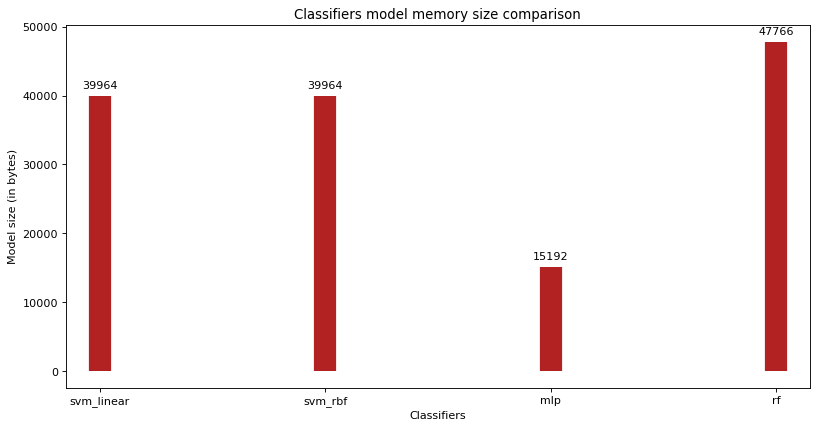

In [40]:
memory = [statinfo_svm_linear, statinfo_svm_rbf, statinfo_mlp, statinfo_rfc]
LABELS = ['svm_linear', 'svm_rbf', 'mlp', 'rf']

fig, ax = plt.subplots(figsize=(12,6), facecolor='white', dpi= 80)
ax.vlines(x=LABELS, ymin=0, ymax=memory, color='firebrick', alpha=1, linewidth=20)

# Annotate Text
for i, value in enumerate(memory):
    ax.text(i, value+1000, round(value,3), horizontalalignment='center')
plt.ylabel('Model size (in bytes)')
plt.xlabel('Classifiers')
plt.title('Classifiers model memory size comparison')
plt.show()

## Discussion:
The classifiers are compared on 5 metrics: 

* Accuracy
* Recall
* Precision
* Training time
* Model memory size
* Memory foot print


The individual illustrations provided in results section compare the metrics and the winner among the classifier is MLP. Though training time is high, MLP won all other metrics. 

SVM-RBF on 5 features extracted from PCA provides a very good precision.

Since accuracy alone cannot be used to decide the best classifier for the given task, recall and precision is also analyzed. 

## References

1. Emre Rencberoglu, "Fundamental Techniques of Feature Engineering for Machine Learning", Towards Datascience, Available at: https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114, Accessed on: 16.11.2019 [Online].

2. Profiling and Optimizing in Jupyter Notebooks - A Comprehensive Guide by Muriz Serifovic
https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025 Accessed on:23-11-2019